<a href="https://colab.research.google.com/github/thekhan314/CovidBrazilMod3/blob/master/COVID_REDUX_last_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Functions


In [1]:
from khantools import *
import pandas as pd
import numpy as np

import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
import operator as operator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

C:\Users\umark\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
# Evaluate empty columns
def cols_with_data(dataframe,threshold,plot=False,axis=0):
    ''' returns a series with all columns that are filled to at least threshold percentage or higher'''
    
    counts = dataframe.count(axis=axis).sort_values()
    
    if axis == 0: 
        counts = counts/len(dataframe)
    else:
        counts = counts/len(dataframe.columns)
        
    non_zero_cols = counts[counts >= threshold ]
    
    if plot == True:
        fig,ax = plt.subplots()
        ax.barh(non_zero_cols.index,non_zero_cols)
        fig.set_size_inches(6,9)
        fig.show()
        print("Features left:{}".format(len(non_zero_cols)))
    return non_zero_cols

def value_counts (df,value, oper):
    ''' takes in a datframe of float values, returns count of zero values '''
    dict = {}
    
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    
    for col in df.columns:
        matches = sum(ops[oper](df[col],value))
        
        dict[col] = matches
    
    df = pd.Series(dict)
    return df


Lets import the data and run a preliminary report

In [3]:
df = pd.read_excel('dataset.xlsx')
report_prelim = report1(df,5)

It appears that the most commonly occuring values aside from the ones that are always there is what appears to be a battery of standard tests. I think it might be a good idea to discard all the rows where these tests were not performed, as they are much too sparse to be of any use to us. Lets keep only rows where standard tests were done, and see if that leaves us with enough data to make a meaningful model.

In [4]:
df = df[df['Parainfluenza 2'].notnull()]
report_post_trim = report1(df,6)
print(len(df))
#display(report_post_trim)

1352


# Data Cleanup and sorting

## Rename & Clean Columns

In [5]:
# Lets change the names of some columns to something easier to work with
new_names = {
    'Patient addmited to intensive care unit (1=yes, 0=no)':'intensive',
    'Patient addmited to semi-intensive unit (1=yes, 0=no)':'semi_int',
    'Patient addmited to regular ward (1=yes, 0=no)':'reg_ward',
    'SARS-Cov-2 exam result':'sars_cov2',
    'Patient age quantile':'age_quant',
    'Patient ID':'patient_id'
}

df = df.rename(columns=new_names)
df.set_index(keys='patient_id',inplace=True)

# convert age_quant to float

df['age_quant'] = df['age_quant'].astype(float)
#delete empty columns

empty_cols = list(report_post_trim[report_post_trim['% empty'] == 100.0].index)
df = df.drop(columns=empty_cols)



## Reduce features

In [6]:
# all data: filled values in each column 
col_fill = cols_with_data(df,threshold=0.03)

meaty_cols = list(col_fill[col_fill > 0.1].index)
meaty_cols.append('Lactic Dehydrogenase')

df = df[meaty_cols]

## Subset features

In [7]:
df_types = df.dtypes

float_features = list(df_types[df_types == 'float64'].index)
obj_features = list(df_types[df_types == 'object'].index)

high_imp= ['Lactic Dehydrogenase','Lymphocytes','Proteina C reativa mg/dL']
admission_features = ['intensive','semi_int','reg_ward']



for col in admission_features:
    df[col] = df[col].astype(float)

## Convert Categoricals

In [8]:
report2 = report1(df[obj_features],3).sort_values('unique values')
display(report2)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%
Parainfluenza 2,object,0.00,1,not_detected,100.00,NaN,NaN
"Influenza B, rapid test",object,80.40,2,negative,18.49,positive,1.11
Rhinovirus/Enterovirus,object,0.00,2,not_detected,71.97,detected,28.03
sars_cov2,object,0.00,2,negative,91.72,positive,8.28
Inf A H1N1 2009,object,0.00,2,not_detected,92.75,detected,7.25
Influenza B,object,0.00,2,not_detected,94.38,detected,5.62
Respiratory Syncytial Virus,object,0.00,2,not_detected,96.15,detected,3.85
CoronavirusNL63,object,0.00,2,not_detected,96.67,detected,3.33
Coronavirus HKU1,object,0.00,2,not_detected,98.52,detected,1.48
"Influenza A, rapid test",object,80.40,2,negative,18.20,positive,1.41


Lets also drop all the unary features because it seems they are all basically negative and dont seem to add much information.

Lets convert the binary categoricals to floats. 

For tests that have a 'not done' value, I will treat 'not done' as negative, since its safe to assume if t he test wasnt done the doctor was expecting a negative anyways. 

Urine Aspect color and crystals I will drop. They dont sound too important, and dont comprise alot of rows.I will also drop standard tests, as I feel they will only add noise.  

Urine PH and Urine Leukocytes should be converted to float



In [9]:
binary_conversions = list(report2[report2['unique values'] == 2].index)

for col in binary_conversions:
    df[col] = df[col].replace(['not_detected','negative','absent','normal'],0)
    df[col] = df[col].replace(['detected','positive','not_done'],1)
    df[col] = df[col].astype(float)

df['sars_cov2'] = df['sars_cov2'].replace(['negative'],0)
df['sars_cov2'] = df['sars_cov2'].replace(['positive'],1)
df.drop('Parainfluenza 2',axis=1,inplace=True)

report3 = report1(df,6)

display(report3)

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%,5nth_value,5nth_value_%,6nth_value,6nth_value_%
Bordetella pertussis,float64,0.00,2,0.000000,99.85,1.000000,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 1,float64,0.00,2,0.000000,99.78,1.000000,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CoronavirusOC43,float64,0.00,2,0.000000,99.41,1.000000,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coronavirus229E,float64,0.00,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,float64,0.00,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 3,float64,0.00,2,0.000000,99.26,1.000000,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adenovirus,float64,0.00,2,0.000000,99.04,1.000000,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Metapneumovirus,float64,0.00,2,0.000000,98.96,1.000000,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Influenza A,float64,0.00,2,0.000000,98.67,1.000000,1.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parainfluenza 4,float64,0.00,2,0.000000,98.59,1.000000,1.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill Empties

In [10]:
full_cols = cols_with_data(df,1)
full_feats = list(full_cols.index)

unfull_feats = list(df.drop(full_feats,axis=1).columns)


In [11]:
filled_feats = full_feats.copy()


for feature in unfull_feats:
    df_vals_present = df.loc[df[feature].notnull()]
    
    X = df_vals_present[filled_feats]
    y = df_vals_present[feature]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if feature in float_features:
        pipe = Ridge(alpha=0.5)
       
        
    elif feature in obj_features:
        
        pipe = LogisticRegression(C=1e5, solver='lbfgs',class_weight='balanced',max_iter=10000)
        
    
    pipe.fit(X,y)
    
    df_predictors = df.loc[df[feature].isna()][filled_feats]
    y_hat = pipe.predict(df_predictors)
    
    df.loc[df[feature].isna(),feature] = y_hat
    
    filled_feats.append(feature)

In [12]:
display(report1(df,4))

,type,% empty,unique values,1nth_value,1nth_value_%,2nth_value,2nth_value_%,3nth_value,3nth_value_%,4nth_value,4nth_value_%
Bordetella pertussis,float64,0.0,2,0.000000,99.85,1.000000,0.15,NaN,NaN,NaN,NaN
Parainfluenza 1,float64,0.0,2,0.000000,99.78,1.000000,0.22,NaN,NaN,NaN,NaN
CoronavirusOC43,float64,0.0,2,0.000000,99.41,1.000000,0.59,NaN,NaN,NaN,NaN
Chlamydophila pneumoniae,float64,0.0,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN
Coronavirus229E,float64,0.0,2,0.000000,99.33,1.000000,0.67,NaN,NaN,NaN,NaN
Parainfluenza 3,float64,0.0,2,0.000000,99.26,1.000000,0.74,NaN,NaN,NaN,NaN
Adenovirus,float64,0.0,2,0.000000,99.04,1.000000,0.96,NaN,NaN,NaN,NaN
Metapneumovirus,float64,0.0,2,0.000000,98.96,1.000000,1.04,NaN,NaN,NaN,NaN
Influenza A,float64,0.0,2,0.000000,98.67,1.000000,1.33,NaN,NaN,NaN,NaN
"Influenza A, rapid test",float64,0.0,2,0.000000,98.59,1.000000,1.41,NaN,NaN,NaN,NaN


## Unified target column

In [13]:
for feat in admission_features:
    df.loc[df[feat] == 1,'adm_status'] = feat

df['adm_status'].fillna(value='not_adm',inplace=True)
df = df.drop(columns=admission_features)

# Train Classifiers

In [14]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)


## Baseline Model 

### Confusion Matrix

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.6s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

   intensive       0.40      0.20      0.27        10
     not_adm       0.93      0.99      0.96       305
    reg_ward       0.67      0.25      0.36        16
    semi_int       0.20      0.14      0.17         7

    accuracy                           0.91       338
   macro avg       0.55      0.39      0.44       338
weighted avg       0.89      0.91      0.89       338



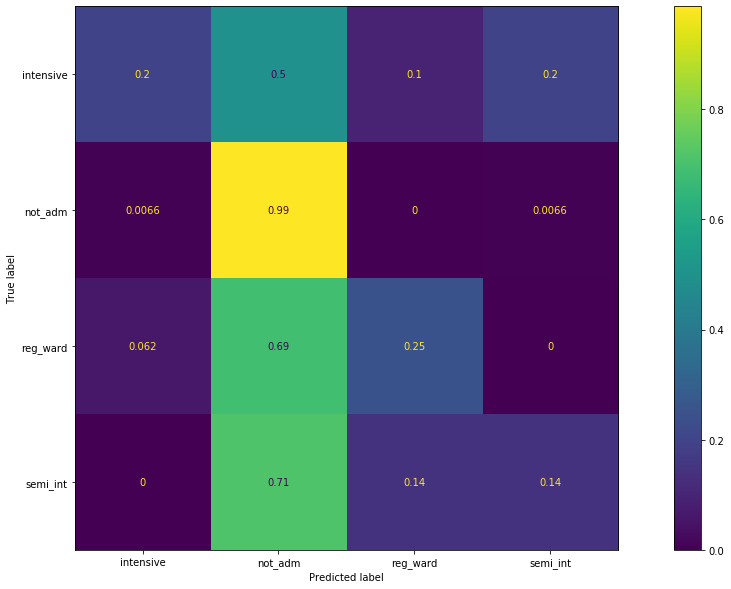

In [15]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
)

gs_base.fit(X_train,y_train)

clf = gs_base.best_estimator_

clf.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(clf,X_test,y_test,ax=ax,normalize='true')

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

We can see that the performance for the minority labels reg_ward,semi_intensive and intensive is really bad. Recall is very low, and that is not good because in this particular context we want recall to be high for the minority classes; we want to find as many people who are at high risk and might need intensive care as we can. Lets build a dictionary to gather the metrics we want the most, and keep track of model performance as we try different models. 


In [16]:
master_dict = {}

In [17]:
report = classification_report(y_test,y_pred,output_dict=True)
pp.pprint(report)

{'accuracy': 0.9112426035502958,
 'intensive': {'f1-score': 0.26666666666666666,
               'precision': 0.4,
               'recall': 0.2,
               'support': 10},
 'macro avg': {'f1-score': 0.439274322169059,
               'precision': 0.5503623188405797,
               'recall': 0.39493559718969556,
               'support': 338},
 'not_adm': {'f1-score': 0.960127591706539,
             'precision': 0.9347826086956522,
             'recall': 0.9868852459016394,
             'support': 305},
 'reg_ward': {'f1-score': 0.36363636363636365,
              'precision': 0.6666666666666666,
              'recall': 0.25,
              'support': 16},
 'semi_int': {'f1-score': 0.16666666666666666,
              'precision': 0.2,
              'recall': 0.14285714285714285,
              'support': 7},
 'weighted avg': {'f1-score': 0.894942102431981,
                  'precision': 0.8910513678072207,
                  'recall': 0.9112426035502958,
                  'support': 338}}


In [18]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'base_clf'

model_type = 'Logistic'

desc = 'Base clasifier', 

weight = 'none'

params = gs_base.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

In [19]:
pp.pprint(master_dict)

{'base_clf': {'description': ('Base clasifier',),
              'intensive_f1': 0.26666666666666666,
              'intensive_precision': 0.4,
              'intensive_recall': 0.2,
              'model_type': 'Logistic',
              'params': {'C': 1000.0, 'max_iter': 10, 'solver': 'liblinear'},
              'reg_ward_f1': 0.36363636363636365,
              'reg_ward_precision': 0.6666666666666666,
              'reg_ward_recall': 0.25,
              'weighting': 'none'}}


### ROC Curves by label

It seems that the 'semi intensive' category is the worst performing one. It might be a better idea to relabel "semit_intensive" data points as something else. Lets look at teh ROC curves to see if its even worthwhile trying to predict semi intensive. 

In [20]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_list = df['adm_status'].value_counts().index.to_list()
y = label_binarize(df['adm_status'],label_list)

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

#X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

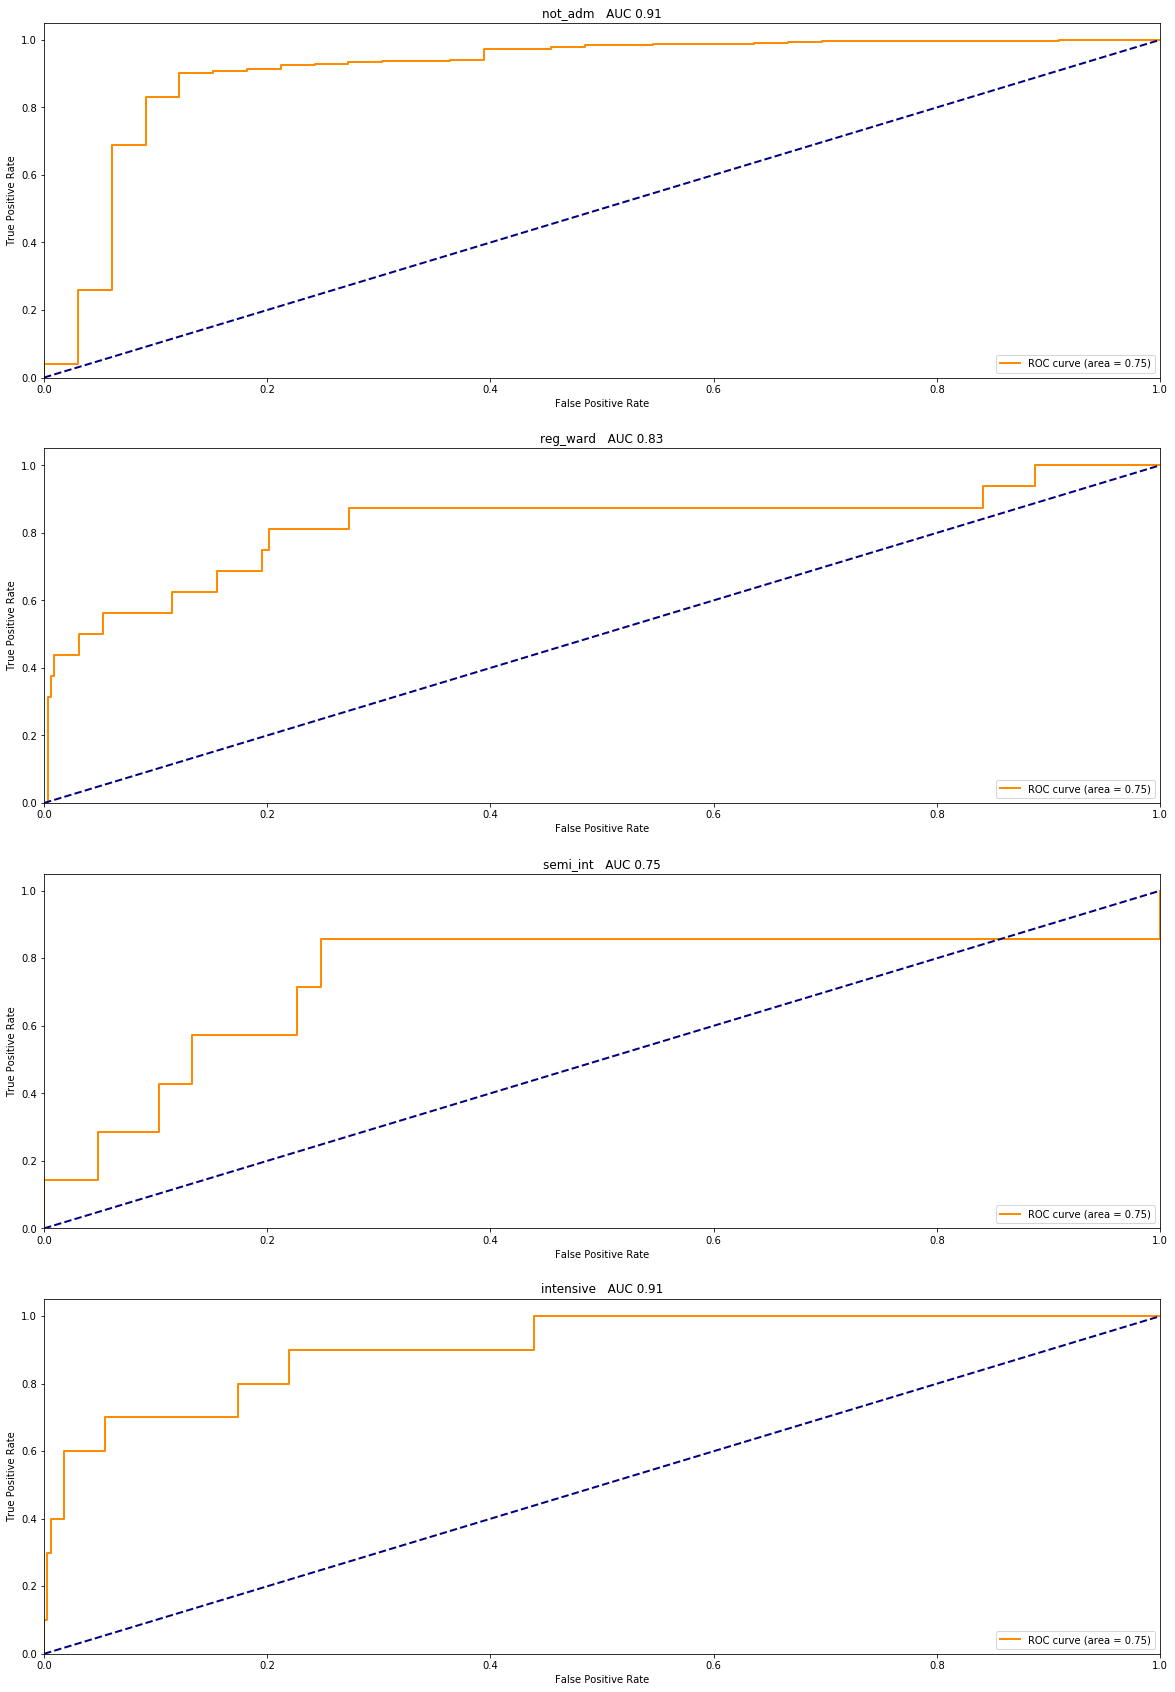

In [21]:
estimator = LogisticRegression(C=1000, solver='liblinear',multi_class='ovr',max_iter=100)

clf = OneVsRestClassifier(estimator)

clf.fit(X_train,y_train)

y_score = clf.decision_function(X_test)
y_pred = clf.predict(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig,ax = plt.subplots(len(label_list),figsize=(20,30))

for i in range(0,len(label_list)):
    ax[i].plot(fpr[i], tpr[i], color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    ax[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(label_list[i] + '   AUC {}'.format(round(roc_auc[i],2)))
    ax[i].legend(loc="lower right")
    



Yes, semi intensive is definitely the worst performing label. It appears to have the lowest AUC. Perhaps using these values to support the other labels will improve their performance .

### Relabel and retry

#### Replace semi_int with reg_ward

Lets replace semi_int labels with reg_Ward. 

In [22]:
df2 = df.copy()

df2['adm_status'].replace('semi_int','reg_ward',inplace=True)

X = df2.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)


y = df2['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.4s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


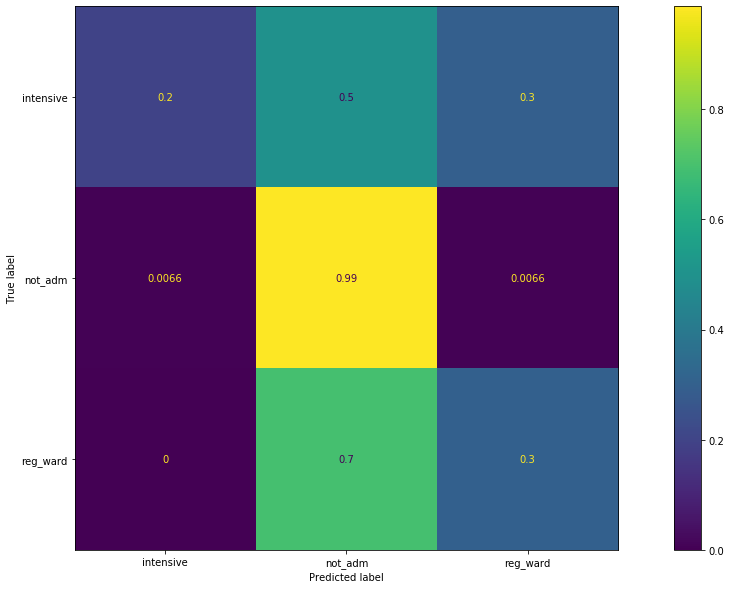

In [23]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
)

gs_base.fit(X_train,y_train)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

In [24]:
y_pred = base_clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

   intensive       0.50      0.20      0.29        10
     not_adm       0.93      0.99      0.96       305
    reg_ward       0.58      0.30      0.40        23

    accuracy                           0.92       338
   macro avg       0.67      0.50      0.55       338
weighted avg       0.90      0.92      0.90       338



In [25]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'base_semi_replaced'

model_type = 'Logistic'

desc = 'replaced Sem_int Int with reg_ward', 

weight = 'none'

params = gs_base.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.266667,0.2,0.4,0.363636,0.250000,0.666667
base_semi_replaced,0.285714,0.2,0.5,0.400000,0.304348,0.583333


It seems that using logistic regression to refill was the best way to go.

In [26]:
rep_df = pd.DataFrame.from_dict(master_dict,orient='index')
display(rep_df)

,model_type,description,params,weighting,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,Logistic,"(Base clasifier,)","{'C': 1000.0, 'max_iter': 10, 'solver': 'liblinear'}",none,0.266667,0.2,0.4,0.363636,0.250000,0.666667
base_semi_replaced,Logistic,"(replaced Sem_int Int with reg_ward,)","{'C': 1e+20, 'max_iter': 10, 'solver': 'liblinear'}",none,0.285714,0.2,0.5,0.400000,0.304348,0.583333


#### Refill semi_int using regression

Lets use a more sophisticated method of replacing semi_int. We will use regression to classify semi_ints as either reg_Ward or intensive.

In [27]:
df3 = df.copy()

semi_indexes = df3.loc[df3['adm_status'] == 'semi_int',:].index.to_list()

df_train = df3.drop(semi_indexes,axis=0)

X = df_train.drop('adm_status',axis=1)
y = df_train['adm_status']

X_test = df3.loc[semi_indexes,:].drop('adm_status',axis=1)

weight_dict = {
    'not_adm': 1,
    'reg_ward': 10,
    'intensive': 70
}

clf = LogisticRegression(C=1000,max_iter=100,solver='liblinear',class_weight=weight_dict)

clf.fit(X,y)

y_predict = clf.predict(X_test)

df3.loc[semi_indexes,'adm_status'] = y_predict

In [28]:
X = df3.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df3['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.6s finished
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\umark\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


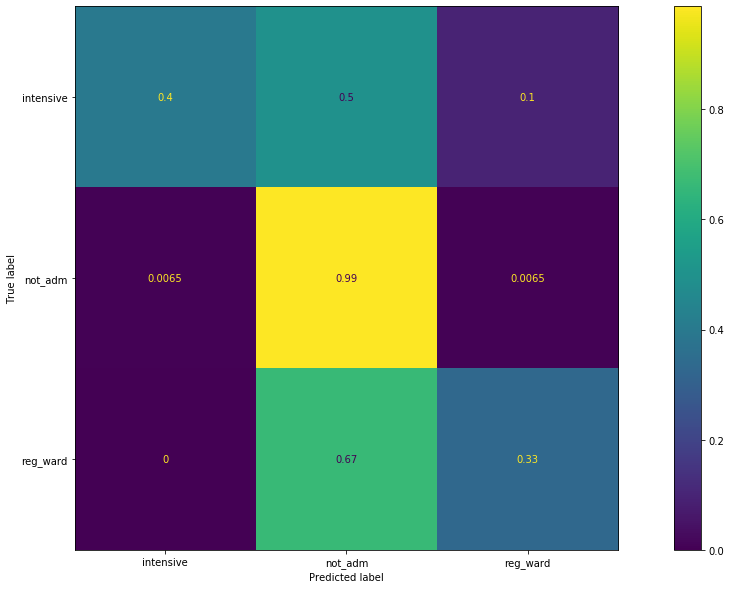

In [29]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
)

gs_base.fit(X_train,y_train)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train,y_train)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

In [30]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'base_semi_refilledf'

model_type = 'Logistic'

desc = 'refilled Semit Int using regression', 

weight = 'none'

params = gs_base.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

,intensive_f1,intensive_recall,intensive_precision,reg_ward_f1,reg_ward_recall,reg_ward_precision
base_clf,0.266667,0.2,0.4,0.363636,0.250000,0.666667
base_semi_replaced,0.285714,0.2,0.5,0.400000,0.304348,0.583333
base_semi_refilledf,0.285714,0.2,0.5,0.424242,0.333333,0.583333


Yes that certainly seems to have helped. 

## Logistic Regresison

### Weights Dictionary

Lets try a more expanded range of Logistic Regression parameters. Lets use explicit weight dictionaries, and lets try to optimize for the recall of intensive in our gridsearch.

In [31]:
weights_dict = [{
    'not_adm':1,
    'reg_ward':20,
    'intensive':60
},{
    'not_adm':1,
    'reg_ward':15,
    'intensive':50
},{
    'not_adm':1,
    'reg_ward':30,
    'intensive':60
},{
    'not_adm':1,
    'reg_ward':40,
    'intensive':100
}
]

In [ ]:
clf = LogisticRegression()


params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100,1000],
    'class_weight':weights_dict
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')

gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_logistic.fit(X_train,y_train)

clf = gs_logistic.best_estimator_

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.9s


In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_recall_dict_weight'

model_type = 'Logistic - Highest Recall'

desc = 'used weights dictionaries in grid search to address imbalance', 

weight = 'Dictionary'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

Let's try maximizing for the f1 score for intensive instead. 

In [ ]:
clf = LogisticRegression()


params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100,1000],
    'class_weight':weights_dict
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_logistic.fit(X_train,y_train)

clf = gs_logistic.best_estimator_

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_f1_dict_weight'

model_type = 'Logistic - Highest F1'

desc = 'used weights dictionaries in grid search to address imbalance, scored with f1', 

weight = 'Dictionary'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

The precision rose but recall went down to .60. Thats the best balance it seems we can find for those two metrics. Maybe SMOTE is a better option. 

### SMOTE

Now lets use SMOTE to reblance our classes and see if it does any better.

In [ ]:
smote = SMOTE()

X = df3.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df3['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

In [ ]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_logistic = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_logistic.fit(X_train_smote,y_train_smote)

base_clf = gs_logistic.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)


In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_recall_smote'

model_type = 'Logistic - Highest Recall'

desc = 'used SMOTE on the training sets, scored with recall', 

weight = 'SMOTE'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

Much better performance! PRecision is still a tad low.Lets see if the best f1 returns better results.

In [ ]:
clf = LogisticRegression()

params = {
    'C': [1e3,1e5,1e10,1e20],
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[10,100],
}

clf = LogisticRegression()

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_base = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_base.fit(X_train_smote,y_train_smote)

base_clf = gs_base.best_estimator_

base_clf.fit(X_train_smote,y_train_smote)

fig,ax = plt.subplots(figsize=(20,10))
base_cf_plot = plot_confusion_matrix(base_clf,X_test,y_test,ax=ax,normalize='true')

y_pred = base_clf.predict(X_test)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'logis_f1_smote'

model_type = 'Logistic - F1'

desc = 'used SMOTE on the training sets, scored with f1', 

weight = 'SMOTE'

params = gs_logistic.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

Looks like the model with the highest recall for intensive also has the highest f1 for intensive. 

## K Nearest Neighbors

Now lets try K- Nearest Neighbors

In [ ]:
clf = KNeighborsClassifier()

params = {
    'n_neighbors': [5,10,15,20],
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree'],
    'leaf_size':[5,10,20,40],
    'p':[1,2,3]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_kneighb_class = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)

gs_kneighb_class.fit(X_train_smote,y_train_smote)

clf = gs_kneighb_class.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'knn_f1_smote'

model_type = 'KNN - F1'

desc = 'KNN on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_kneighb_class.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

## Decision Tree

In [ ]:
clf = DecisionTreeClassifier()

params = {
    'criterion': ['entropy','gini'],
    'splitter':['best', 'random'],
    'max_depth':[i for i in np.linspace(1, 32, 8, endpoint=True)],
    'min_samples_split':[i for i in np.linspace(0.1, 1.0, 10, endpoint=True)],
    'min_samples_leaf':[i for i in np.linspace(0.1, 0.5, 5, endpoint=True)]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_dec_tree = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_dec_tree.fit(X_train_smote,y_train_smote)

clf = gs_dec_tree.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred)

print(class_report_1)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'dec_tree_f1_smote'

model_type = 'Decision Tree - F1'

desc = 'Decision Tree on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_dec_tree.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

## Random Forest

In [ ]:
clf = RandomForestClassifier()

params = {
    'criterion': ['entropy','gini'],
    'max_depth':[2,6,14,24,32],
    'min_samples_split':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_random_forest = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_random_forest.fit(X_train_smote,y_train_smote)

clf = gs_random_forest.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'rand_forest_f1_smote'

model_type = 'Random Forest - F1'

desc = 'Random Forest on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_random_forest.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

## XGboost

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier( objective='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,scale_pos_weight=15)
clf.fit(X_train_smote,y_train_smote)

y_score = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_score)


print(class_report_1)

In [ ]:
clf = xgb.XGBClassifier()

param_grid = {
    "learning_rate": [0.01,0.05,0.2,0.5,0.9],
    'max_depth': [2,4,6,8,12],
    'min_child_weight': [1,10,100],
    'subsample': [0.5,0.75,1.0],
    'n_estimators': [10,20,40]
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')

gs_xgboost = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_xgboost.fit(X_train_smote,y_train_smote)

clf = gs_xgboost.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'xgboostt_f1_smote'

model_type = 'XGBoost - F1'

desc = 'XGBOOST on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_xgboost.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

### Recall

In [ ]:
clf = xgb.XGBClassifier()

param_grid = {
    "learning_rate": [0.01,0.05,0.2,0.5,0.9],
    'max_depth': [2,4,6,8,12],
    'min_child_weight': [1,10,100],
    'subsample': [0.5,0.75,1.0],
    'n_estimators': [10,20,40]
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')

gs_xgboost = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_xgboost.fit(X_train_smote,y_train_smote)

clf = gs_xgboost.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'xgboostt_recall_smote'

model_type = 'XGBoost - Recall'

desc = 'XGBOOST on SMOTE, scored with Recall', 

weight = 'SMOTE'

params = gs_xgboost.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

## Support Vector Machines

In [ ]:
clf = SVC()

params = {
    'C':[1,100,1000],
    'kernel':['linear','rbf'],
    'degree': [2,3,4],
    'gamma':['scale']
}

scorer = make_scorer(f1_score, labels=['intensive'],average = 'macro')
gs_svc = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_svc.fit(X_train_smote,y_train_smote)

clf = gs_svc.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)

class_report_1 = classification_report(y_test,y_pred,output_dict=True)
report = pd.DataFrame(class_report_1)
print(report)

In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'gs_svc_f1_smote'

model_type = 'SVC - F1'

desc = 'SVC on SMOTE, scored with f1', 

weight = 'SMOTE'

params = gs_svc.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

In [ ]:
clf = SVC()

params = {
    'C':[1,100,1000],
    'kernel':['linear','rbf'],
    'degree': [2,3,4],
    'gamma':['scale']
}

scorer = make_scorer(recall_score, labels=['intensive'],average = 'macro')
gs_svc = GridSearchCV(
    estimator=clf,
    param_grid=params,
    cv=5,
    n_jobs = -1,
    verbose = 1,
    scoring = scorer
)
gs_svc.fit(X_train_smote,y_train_smote)

gs_svc.best_score_
gs_svc.best_params_


clf = gs_svc.best_estimator_

clf.fit(X_train_smote,y_train_smote)

y_pred = clf.predict(X_test)



In [ ]:
report = classification_report(y_test,y_pred,output_dict=True)

iter_name = 'gs_svc_recall_smote'

model_type = 'SVC - Recall'

desc = 'SVC on SMOTE, scored with Recall', 

weight = 'SMOTE'

params = gs_svc.best_params_

iter_dict={
    'model_type':model_type,
    'description':desc,
    'params':params,
    'weighting':weight,
    'intensive_f1':report['intensive']['f1-score'],
    'intensive_recall':report['intensive']['recall'],
    'intensive_precision':report['intensive']['precision'],
    'reg_ward_f1':report['reg_ward']['f1-score'],
    'reg_ward_recall':report['reg_ward']['recall'],
    'reg_ward_precision':report['reg_ward']['precision'],
    
}

master_dict[iter_name] = iter_dict

rep_df = pd.DataFrame.from_dict(master_dict,orient='index')

display(rep_df.drop(['model_type','description','params','weighting'],axis=1))

# Model Evaluation

## Best Model

## Feature Importance

In [ ]:
import shap

shap_values = shap.TreeExplainer

In [ ]:
master_dict['gs_svc_recall_smote']

In [ ]:
clf.coef_

In [ ]:
feature_ranks = pd.Series(abs(clf.coef_[0]), index=df3.drop('adm_status',axis=1).columns)
feature_ranks.sort_values(ascending=True,inplace=True)
feature_ranks.plot(kind='barh',figsize=(20,30))


# scraps

In [ ]:
smote = SMOTE()

X = df.drop('adm_status',axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df['adm_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.25, random_state=42)

#X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 

In [ ]:
from sklearn.metrics import precision_recall_curve
estimator = clf
ovr = OneVsRestClassifier(estimator)

ovr.fit(X_train_resampled,y_train_resampled)

y_score = ovr.decision_function(X_test)
y_pred = ovr.predict(X_test)
n_classes = y.shape[1]

precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

fig,ax = plt.subplots(len(label_list),figsize=(20,40))

for i in range(0,len(label_list)):
    ax[i].plot(recall[i],precision[i], color='darkorange',
            lw=2)
    
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('recall')
    ax[i].set_ylabel('precision')
    ax[i].set_title(label_list[i])
    ax[i].legend(loc="lower right")
    
    